In [2]:
import numpy as np
import time
from keras.models import load_model
from solver_backtracking import solve_backtrack, Step
from utils import evaluate_solution
from ac3 import initialize_domains, get_constraints, AC3, revise

In [6]:
class HybridSudokuSolver:
    def __init__(self, model_path, confidence_threshold=0.95, use_ac3=True):
        self.model = load_model(model_path)
        self.confidence_threshold = confidence_threshold
        self.use_ac3 = use_ac3
    
    def initialize_domains(self, board):
        """Initialize domains for AC3 based on the current board state"""
        domains = {}
        for i in range(9):
            for j in range(9):
                pos = (i, j)
                if board[i][j] == 0:
                    # Start with all possible values
                    domains[pos] = set(range(1, 10))
                    # Remove values that violate constraints
                    for val in list(domains[pos]):
                        if not self.is_valid_move(board, i, j, val):
                            domains[pos].discard(val)
                else:
                    domains[pos] = {board[i][j]}
        return domains
    
    def get_sudoku_constraints(self):
        """Generate all constraints for Sudoku puzzle"""
        constraints = set()
        
        # Row constraints
        for i in range(9):
            for j in range(9):
                for k in range(j + 1, 9):
                    constraints.add(((i, j), (i, k)))
        
        # Column constraints
        for j in range(9):
            for i in range(9):
                for k in range(i + 1, 9):
                    constraints.add(((i, j), (k, j)))
        
        # Box constraints
        for box_row in range(3):
            for box_col in range(3):
                cells = []
                for r in range(3):
                    for c in range(3):
                        cells.append((box_row * 3 + r, box_col * 3 + c))
                
                for i in range(len(cells)):
                    for j in range(i + 1, len(cells)):
                        constraints.add((cells[i], cells[j]))
        
        return list(constraints)
    
    def revise(self, domains, Xi, Xj):
        """Revise domain of Xi to be arc-consistent with Xj"""
        revised = False
        for i in list(domains[Xi]):
            found = False
            for j in domains[Xj]:
                if i != j:  # Sudoku constraint: values must be different
                    found = True
                    break
            if not found:
                domains[Xi].remove(i)
                revised = True
        return revised
    
    def AC3(self, domains, constraints):
        """AC3 algorithm for arc consistency"""
        agenda = []
        for (Xi, Xj) in constraints:
            agenda.append((Xi, Xj))
            agenda.append((Xj, Xi))
        
        arcs = agenda.copy()
        
        while len(agenda) > 0:
            (Xi, Xj) = agenda.pop()
            xi_copy = domains[Xi].copy()
            
            if self.revise(domains, Xi, Xj):
                if len(domains[Xi]) == 0:
                    return False  # No solution exists
            
            if domains[Xi] != xi_copy:
                # Add all arcs (Xk, Xi) back to agenda
                for cur_arc in arcs:
                    if cur_arc[1] == Xi and cur_arc[0] != Xj:
                        agenda.append(cur_arc)
        
        return True
    
    def apply_ac3_preprocessing(self, board):
        """Apply AC3 to reduce domains and possibly fill some cells"""
        print("\n0. APPLYING AC3 PREPROCESSING...")
        ac3_start_time = time.time()
        
        # Initialize domains based on current board
        domains = self.initialize_domains(board)
        
        # Get Sudoku constraints
        constraints = self.get_sudoku_constraints()
        
        # Run AC3
        is_consistent = self.AC3(domains, constraints)
        
        if not is_consistent:
            print("AC3 detected inconsistency - puzzle may be unsolvable")
            return board, 0, 0
        
        # Apply singleton domains (cells with only one possible value)
        ac3_board = board.copy()
        cells_filled = 0
        cells_reduced = 0
        
        for pos, domain in domains.items():
            i, j = pos
            if ac3_board[i][j] == 0:
                if len(domain) == 1:
                    # Only one possible value - fill it
                    ac3_board[i][j] = list(domain)[0]
                    cells_filled += 1
                elif len(domain) < 9:
                    cells_reduced += 1
        
        ac3_time = time.time() - ac3_start_time
        
        print(f"AC3 preprocessing completed in {ac3_time:.4f} seconds")
        print(f"Cells filled by AC3: {cells_filled}")
        print(f"Cells with reduced domains: {cells_reduced}")
        
        # Store domains for potential use in backtracking
        self.ac3_domains = domains
        
        return ac3_board, cells_filled, ac3_time
    
    def is_valid_move(self, board, row, col, num):
        """Check if a move is valid (doesn't violate Sudoku rules)"""
        if num == 0:
            return True
            
        # Check row
        if num in board[row, :]:
            return False
        
        # Check column
        if num in board[:, col]:
            return False
        
        # Check 3x3 box
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        box = board[box_row:box_row+3, box_col:box_col+3]
        if num in box:
            return False
        
        return True
    
    def print_board(self, board, title="Board"):
        """Print the sudoku board in a readable format"""
        print(f"\n{title}:")
        print("-" * 25)
        for i in range(9):
            if i % 3 == 0 and i != 0:
                print("-" * 25)
            row_str = ""
            for j in range(9):
                if j % 3 == 0 and j != 0:
                    row_str += "| "
                cell_value = board[i, j]
                row_str += f"{cell_value if cell_value != 0 else '.'} "
            print(row_str)
        print("-" * 25)
    
    def get_model_predictions(self, board):
        """Get model predictions for the current board state"""
        # Normalize input
        board_norm = board.astype(np.float32) / 9.0 - 0.5
        input_board = board_norm.reshape(1, 9, 9, 1)
        
        # Get predictions
        pred = self.model.predict(input_board, verbose=0)
        
        # Get predicted digits and their probabilities
        predicted_digits = np.argmax(pred[0], axis=-1) + 1
        probabilities = np.max(pred[0], axis=-1)
        
        return predicted_digits, probabilities
    
    def solve_with_cnn_first(self, puzzle, true_solution):
        """Use AC3, then CNN for high-confidence predictions, then backtracking for the rest"""
        original_board = np.array(puzzle, dtype=int)
        true_solution = np.array(true_solution, dtype=int)
        
        print("=" * 60)
        print("HYBRID SUDOKU SOLVER: AC3 + CNN + BACKTRACKING")
        print("=" * 60)
        
        # Step 0: Apply AC3 preprocessing if enabled
        if self.use_ac3:
            ac3_board, ac3_cells_filled, ac3_time = self.apply_ac3_preprocessing(original_board)
            
            if ac3_cells_filled > 0:
                self.print_board(ac3_board, "AFTER AC3 PREPROCESSING")
                
                # Check if AC3 solved it completely
                if np.array_equal(ac3_board, true_solution):
                    print("\n🎉 AC3 SOLVED THE PUZZLE COMPLETELY!")
                    return ac3_board, ac3_time, 0, 0, 1.0, 1.0
            
            # Use AC3-preprocessed board for CNN
            current_board = ac3_board
        else:
            current_board = original_board
            ac3_time = 0
            ac3_cells_filled = 0
        
        # Step 1: Run CNN and get high-confidence predictions
        print("\n1. RUNNING CNN PREDICTIONS...")
        cnn_start_time = time.time()
        
        predicted_digits, probabilities = self.get_model_predictions(current_board)
        cnn_partial_board = current_board.copy()
        
        # Only fill cells where CNN has high confidence AND the cell is empty AND the move is valid
        empty_mask = current_board == 0
        high_confidence_mask = probabilities > self.confidence_threshold
        cells_to_fill = empty_mask & high_confidence_mask
        
        print(f"CNN confidence threshold: {self.confidence_threshold}")
        print(f"High-confidence predictions: {np.sum(cells_to_fill)} cells")
        
        # If AC3 was used, also check against reduced domains
        valid_predictions = 0
        invalid_predictions = 0
        
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j]:
                    predicted_value = predicted_digits[i, j]
                    is_valid = self.is_valid_move(cnn_partial_board, i, j, predicted_value)
                    
                    # Additional check against AC3 domains if available
                    if self.use_ac3 and hasattr(self, 'ac3_domains'):
                        if (i, j) in self.ac3_domains:
                            is_valid = is_valid and (predicted_value in self.ac3_domains[(i, j)])
                    
                    if is_valid:
                        cnn_partial_board[i, j] = predicted_value
                        valid_predictions += 1
                    else:
                        invalid_predictions += 1
                        cells_to_fill[i, j] = False
        
        cnn_time = time.time() - cnn_start_time
        
        # Calculate REAL accuracy (against true solution, not just validity)
        cnn_filled_cells = np.sum(cells_to_fill)
        cnn_correct_predictions = 0
        
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j]:
                    if cnn_partial_board[i, j] == true_solution[i, j]:
                        cnn_correct_predictions += 1
        
        cnn_accuracy = cnn_correct_predictions / cnn_filled_cells if cnn_filled_cells > 0 else 0.0
        
        self.print_board(original_board, "ORIGINAL PUZZLE")
        self.print_board(cnn_partial_board, "AFTER CNN (HIGH-CONFIDENCE + VALID PREDICTIONS)")
        
        print(f"\nCNN RESULTS:")
        print(f"Time taken: {cnn_time:.4f} seconds")
        print(f"High-confidence cells found: {valid_predictions + invalid_predictions}")
        print(f"  Valid predictions: {valid_predictions}")
        print(f"  Invalid predictions: {invalid_predictions} (not filled)")
        print(f"Cells actually filled by CNN: {cnn_filled_cells}")
        print(f"CNN prediction accuracy: {cnn_accuracy * 100:.2f}%")
        print(f"Remaining empty cells: {np.sum(cnn_partial_board == 0)}")
        
        # Check if CNN solved it completely
        if np.array_equal(cnn_partial_board, true_solution):
            print("\n🎉 CNN SOLVED THE PUZZLE COMPLETELY!")
            return cnn_partial_board, ac3_time, cnn_time, 0, cnn_accuracy, 1.0
        
        # Step 2: Use backtracking for remaining empty cells
        remaining_empty = np.sum(cnn_partial_board == 0)
        print(f"\n2. RUNNING BACKTRACKING FOR {remaining_empty} REMAINING CELLS...")
        backtrack_start_time = time.time()
        
        # Use backtracking to solve remaining cells
        backtrack_board = cnn_partial_board.copy()
        steps = []
        
        # Use AC3 domains in backtracking if available
        if self.use_ac3 and hasattr(self, 'ac3_domains'):
            success = self.solve_backtrack_with_domains(backtrack_board, steps, self.ac3_domains)
        else:
            success = solve_backtrack(backtrack_board, steps)
        
        backtrack_time = time.time() - backtrack_start_time
        
        if success:
            # Final evaluation
            final_empty_acc, final_all_acc = evaluate_solution(backtrack_board, original_board, true_solution)
            
            self.print_board(backtrack_board, "FINAL SOLUTION (AFTER BACKTRACKING)")
            
            print(f"\nBACKTRACKING RESULTS:")
            print(f"Time taken: {backtrack_time:.4f} seconds")
            print(f"Number of backtracking steps: {len(steps)}")
            print(f"Remaining cells solved correctly: {final_empty_acc * 100:.2f}%")
            print(f"Final all cells accuracy: {final_all_acc * 100:.2f}%")
            
            # Summary
            print("\n" + "=" * 60)
            print("SUMMARY:")
            print(f"AC3 preprocessing: {ac3_time:.4f}s, filled {ac3_cells_filled} cells")
            print(f"CNN predictions: {cnn_time:.4f}s, filled {cnn_filled_cells} cells")
            print(f"Backtracking: {backtrack_time:.4f}s, filled {remaining_empty} cells")
            print(f"Total time: {ac3_time + cnn_time + backtrack_time:.4f}s")
            
            # Verify final solution
            if np.array_equal(backtrack_board, true_solution):
                print("🎉 PUZZLE SOLVED CORRECTLY!")
            else:
                print("❌ Final solution does not match expected result")
                print("Expected solution:")
                self.print_board(true_solution, "EXPECTED SOLUTION")
            
            return backtrack_board, ac3_time, cnn_time, backtrack_time, cnn_accuracy, final_all_acc
        
        else:
            print("❌ Backtracking failed to solve the puzzle")
            return None, ac3_time, cnn_time, backtrack_time, cnn_accuracy, 0.0
    
    def solve_backtrack_with_domains(self, board, steps, domains):
        """Backtracking with AC3 domain information for optimization"""
        # Find empty cell with smallest domain (MRV heuristic)
        min_domain_size = 10
        best_cell = None
        
        for i in range(9):
            for j in range(9):
                if board[i][j] == 0:
                    if (i, j) in domains:
                        domain_size = len(domains[(i, j)])
                        if domain_size < min_domain_size:
                            min_domain_size = domain_size
                            best_cell = (i, j)
        
        if best_cell is None:
            return True  # No empty cells, puzzle solved
        
        row, col = best_cell
        
        # Try values from the domain
        if best_cell in domains:
            for num in domains[best_cell]:
                if self.is_valid_move(board, row, col, num):
                    board[row][col] = num
                    steps.append((row, col, num))
                    
                    if self.solve_backtrack_with_domains(board, steps, domains):
                        return True
                    
                    board[row][col] = 0
                    steps.append((row, col, 0))
        
        return False


# Helper functions that should be defined elsewhere in your code
def solve_backtrack(board, steps):
    """Standard backtracking solver without domain information"""
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                for num in range(1, 10):
                    if is_valid_move_standalone(board, i, j, num):
                        board[i][j] = num
                        steps.append((i, j, num))
                        
                        if solve_backtrack(board, steps):
                            return True
                        
                        board[i][j] = 0
                        steps.append((i, j, 0))
                
                return False
    
    return True

def is_valid_move_standalone(board, row, col, num):
    """Standalone version of is_valid_move for backtracking"""
    if num in board[row, :]:
        return False
    if num in board[:, col]:
        return False
    box_row, box_col = 3 * (row // 3), 3 * (col // 3)
    box = board[box_row:box_row+3, box_col:box_col+3]
    if num in box:
        return False
    return True

def evaluate_solution(solution, original, true_solution):
    """Evaluate the accuracy of the solution"""
    empty_mask = original == 0
    empty_correct = np.sum((solution == true_solution) & empty_mask)
    empty_total = np.sum(empty_mask)
    empty_acc = empty_correct / empty_total if empty_total > 0 else 0.0
    
    all_correct = np.sum(solution == true_solution)
    all_acc = all_correct / 81
    
    return empty_acc, all_acc

Creating a dummy model for demonstration...
RUNNING HYBRID SOLVER BENCHMARK SUITE

📊 Testing Model: CNN_256_filters (AC3=On, Conf=0.90)
------------------------------------------------------------
  Difficulty: EASY
    Puzzle 1, Run 1: Time: 1.0816s (AC3: 8, CNN: 9) Solved: ✓
    Puzzle 1, Run 2: Time: 0.0960s (AC3: 8, CNN: 9) Solved: ✓
  Difficulty: MEDIUM
    Puzzle 1, Run 1: Time: 0.0825s (AC3: 22, CNN: 16) Solved: ✓
    Puzzle 1, Run 2: Time: 0.0864s (AC3: 22, CNN: 16) Solved: ✓
  Difficulty: HARD
    Puzzle 1, Run 1: Time: 19.8579s (AC3: 0, CNN: 1) Solved: ✓
    Puzzle 1, Run 2: Time: 19.6503s (AC3: 0, CNN: 1) Solved: ✓

📊 Testing Model: CNN_256_filters (AC3=On, Conf=0.95)
------------------------------------------------------------
  Difficulty: EASY
    Puzzle 1, Run 1: Time: 0.7083s (AC3: 8, CNN: 8) Solved: ✓
    Puzzle 1, Run 2: Time: 0.0883s (AC3: 8, CNN: 8) Solved: ✓
  Difficulty: MEDIUM
    Puzzle 1, Run 1: Time: 0.0825s (AC3: 22, CNN: 15) Solved: ✓
    Puzzle 1, Run 2: Ti

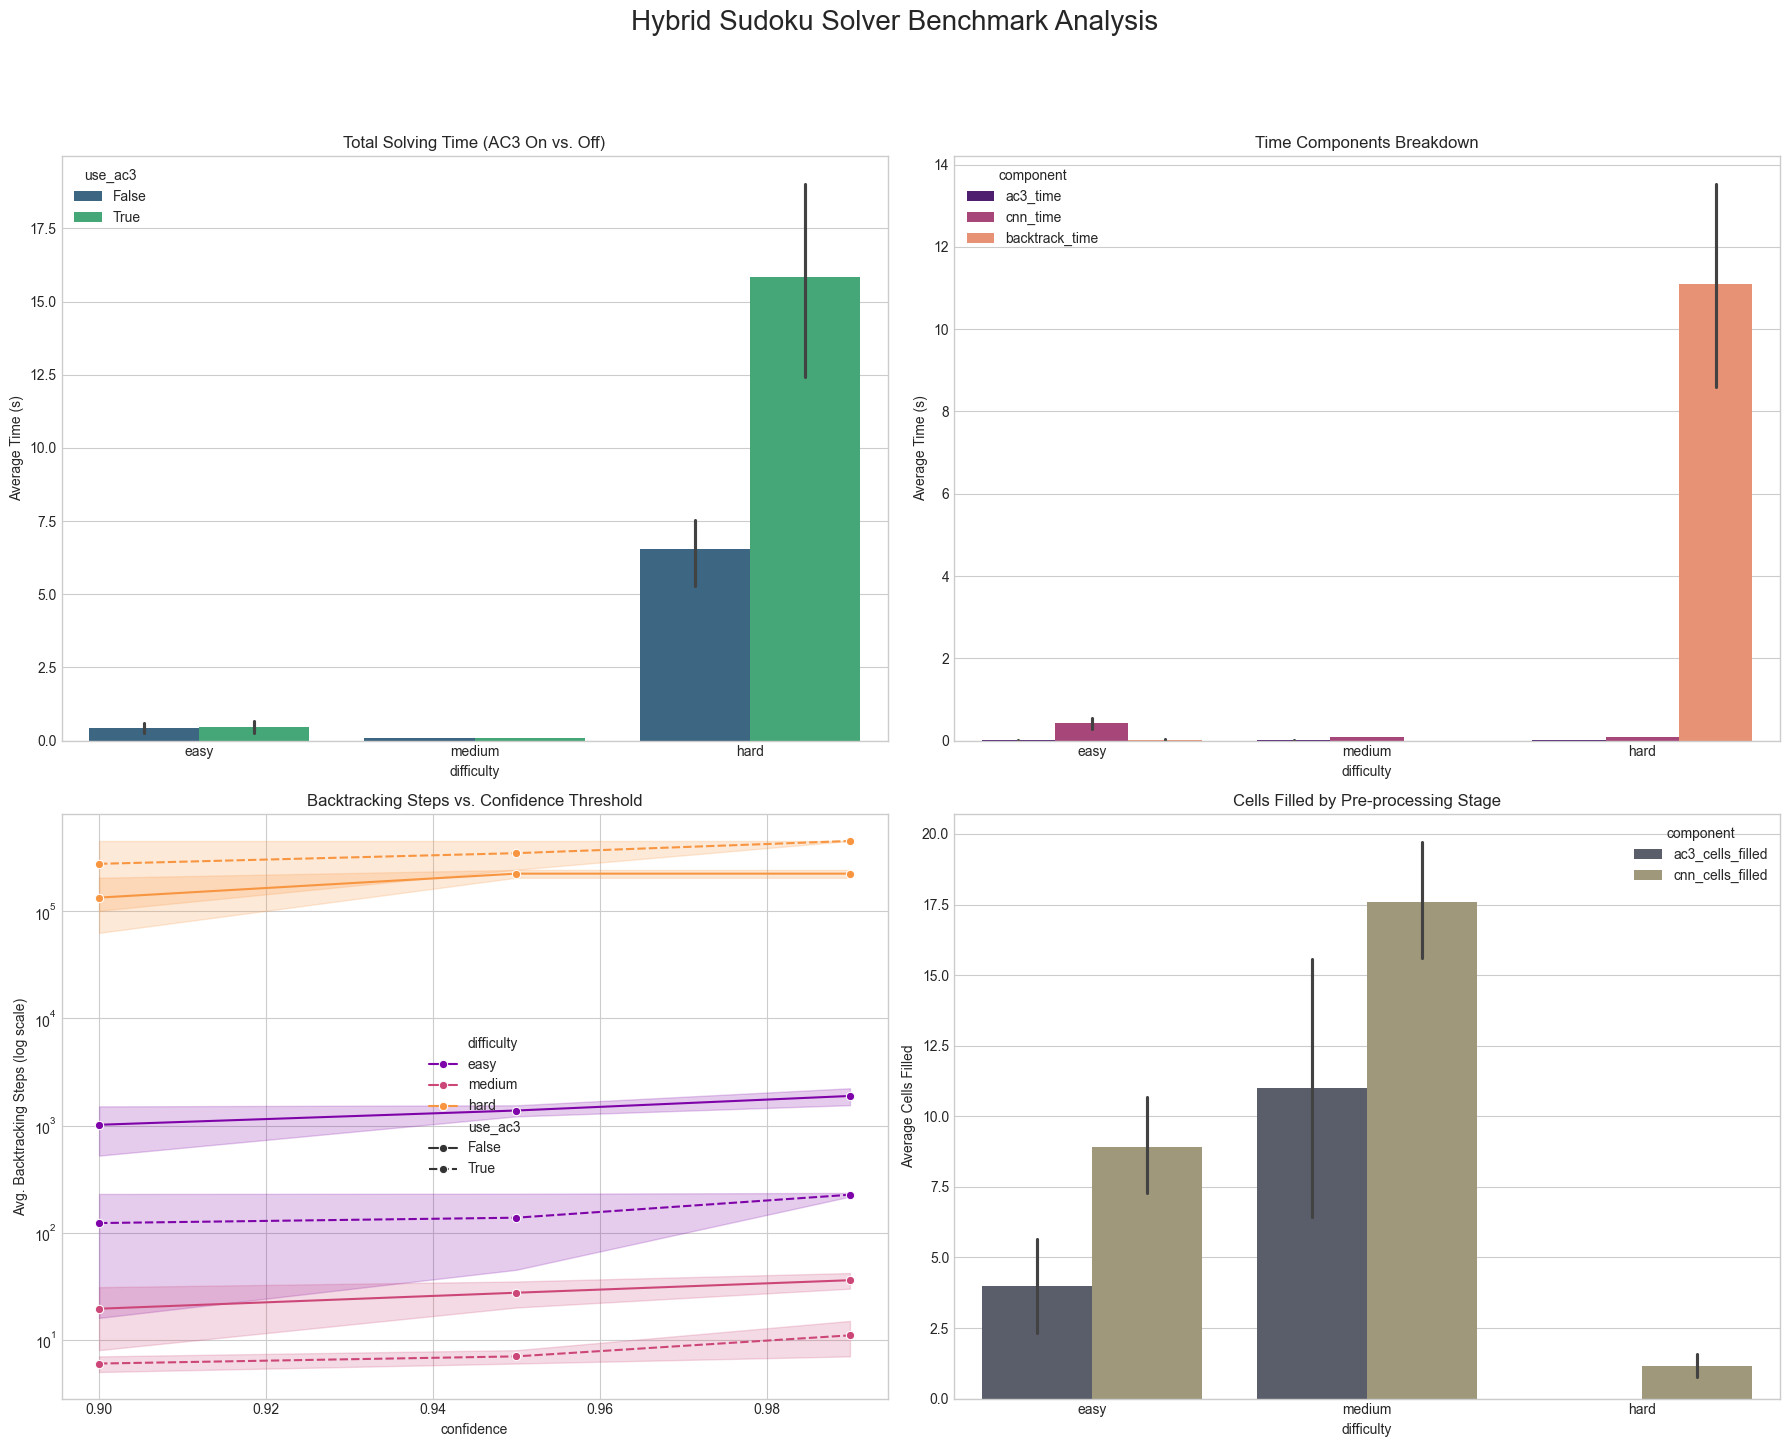

In [7]:
import pandas as pd
import numpy as np
import time
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple

# Keras is part of TensorFlow, so we import from there
import tensorflow as tf


# --- Helper Functions (from your notebook) ---
def is_valid_move_standalone(board, row, col, num):
    """Standalone version of is_valid_move for backtracking without a class instance."""
    if num in board[row, :]: return False
    if num in board[:, col]: return False
    box_row, box_col = 3 * (row // 3), 3 * (col // 3)
    box = board[box_row:box_row+3, box_col:box_col+3]
    if num in box: return False
    return True

def solve_backtrack(board, steps):
    """Standard backtracking solver."""
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                for num in range(1, 10):
                    if is_valid_move_standalone(board, i, j, num):
                        board[i][j] = num
                        steps.append((i, j, num))
                        if solve_backtrack(board, steps):
                            return True
                        board[i][j] = 0 # Backtrack
                        steps.append((i, j, 0))
                return False # No valid number found
    return True # Puzzle solved

def evaluate_solution(solution, original, true_solution):
    """Evaluates the accuracy of the final solution."""
    empty_mask = original == 0
    empty_correct = np.sum((solution == true_solution) & empty_mask)
    empty_total = np.sum(empty_mask)
    empty_acc = empty_correct / empty_total if empty_total > 0 else 0.0
    all_correct = np.sum(solution == true_solution)
    all_acc = all_correct / 81
    return empty_acc, all_acc


# --- Modified Solver for Benchmarking ---
class BenchmarkedHybridSudokuSolver:
    """
    This is your solver from the notebook, slightly modified to return
    the number of backtracking steps for more detailed benchmarking analysis.
    """
    def __init__(self, model_path, confidence_threshold=0.95, use_ac3=True):
        self.model = load_model(model_path)
        self.confidence_threshold = confidence_threshold
        self.use_ac3 = use_ac3
        self.ac3_domains = {}

    def initialize_domains(self, board):
        domains = {}
        for i in range(9):
            for j in range(9):
                pos = (i, j)
                if board[i, j] == 0:
                    domains[pos] = set(range(1, 10))
                    for val in list(domains[pos]):
                        if not self.is_valid_move(board, i, j, val):
                            domains[pos].discard(val)
                else:
                    domains[pos] = {board[i, j]}
        return domains

    def get_sudoku_constraints(self):
        constraints = set()
        for i in range(9): # Rows
            for j in range(9):
                for k in range(j + 1, 9): constraints.add(((i, j), (i, k)))
        for j in range(9): # Columns
            for i in range(9):
                for k in range(i + 1, 9): constraints.add(((i, j), (k, j)))
        for box_row in range(3): # Boxes
            for box_col in range(3):
                cells = [(box_row * 3 + r, box_col * 3 + c) for r in range(3) for c in range(3)]
                for i in range(len(cells)):
                    for j in range(i + 1, len(cells)): constraints.add((cells[i], cells[j]))
        return list(constraints)

    def revise(self, domains, Xi, Xj):
        revised = False
        for i in list(domains[Xi]):
            if not any(i != j for j in domains[Xj]):
                domains[Xi].remove(i)
                revised = True
        return revised

    def AC3(self, domains, constraints):
        agenda = constraints.copy()
        while agenda:
            (Xi, Xj) = agenda.pop(0)
            if self.revise(domains, Xi, Xj):
                if not domains[Xi]: return False
                neighbors = [Xk for (Xk, Xl) in constraints if Xl == Xi and Xk != Xj]
                for Xk in neighbors:
                    agenda.append((Xk, Xi))
        return True

    def apply_ac3_preprocessing(self, board):
        ac3_start_time = time.time()
        domains = self.initialize_domains(board)
        constraints = self.get_sudoku_constraints()
        is_consistent = self.AC3(domains, constraints)
        if not is_consistent:
            return board, 0, time.time() - ac3_start_time, False
        ac3_board = board.copy()
        cells_filled = 0
        for pos, domain in domains.items():
            i, j = pos
            if ac3_board[i, j] == 0 and len(domain) == 1:
                ac3_board[i, j] = list(domain)[0]
                cells_filled += 1
        ac3_time = time.time() - ac3_start_time
        self.ac3_domains = domains
        return ac3_board, cells_filled, ac3_time, True

    def is_valid_move(self, board, row, col, num):
        if num == 0: return True
        if num in board[row, :]: return False
        if num in board[:, col]: return False
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        if num in board[box_row:box_row+3, box_col:box_col+3]: return False
        return True

    def get_model_predictions(self, board):
        board_norm = board.astype(np.float32) / 9.0 - 0.5
        input_board = board_norm.reshape(1, 9, 9, 1)
        pred = self.model.predict(input_board, verbose=0)
        return np.argmax(pred[0], axis=-1) + 1, np.max(pred[0], axis=-1)

    def solve_with_cnn_first(self, puzzle, true_solution):
        original_board = np.array(puzzle, dtype=int)
        true_solution = np.array(true_solution, dtype=int)
        
        ac3_time, ac3_cells_filled = 0, 0
        current_board = original_board.copy()

        if self.use_ac3:
            ac3_board, ac3_cells_filled, ac3_time, is_consistent = self.apply_ac3_preprocessing(current_board)
            if not is_consistent: return None, 0,0,0,0,0,0,0,0
            if np.array_equal(ac3_board, true_solution):
                return ac3_board, ac3_time, 0, 0, 0, 1.0, 0, ac3_cells_filled, 0
            current_board = ac3_board

        cnn_start_time = time.time()
        predicted_digits, probabilities = self.get_model_predictions(current_board)
        cnn_partial_board = current_board.copy()
        
        cells_to_fill_mask = (current_board == 0) & (probabilities > self.confidence_threshold)
        
        for i, j in np.argwhere(cells_to_fill_mask):
            predicted_value = predicted_digits[i, j]
            is_valid = self.is_valid_move(cnn_partial_board, i, j, predicted_value)
            if self.use_ac3 and predicted_value not in self.ac3_domains.get((i, j), {predicted_value}):
                is_valid = False
            if is_valid:
                cnn_partial_board[i, j] = predicted_value

        cnn_time = time.time() - cnn_start_time
        cnn_filled_mask = (cnn_partial_board != current_board)
        cnn_filled_cells = np.sum(cnn_filled_mask)
        cnn_correct_predictions = np.sum((cnn_partial_board == true_solution) & cnn_filled_mask)
        cnn_accuracy = cnn_correct_predictions / cnn_filled_cells if cnn_filled_cells > 0 else 0.0

        if np.array_equal(cnn_partial_board, true_solution):
            return cnn_partial_board, ac3_time, cnn_time, 0, cnn_accuracy, 1.0, 0, ac3_cells_filled, cnn_filled_cells
            
        backtrack_start_time = time.time()
        backtrack_board = cnn_partial_board.copy()
        steps = []
        
        success = self.solve_backtrack_with_domains(backtrack_board, steps) if self.use_ac3 else solve_backtrack(backtrack_board, steps)
        backtrack_time = time.time() - backtrack_start_time
        
        if success:
            _, final_all_acc = evaluate_solution(backtrack_board, original_board, true_solution)
            return (backtrack_board, ac3_time, cnn_time, backtrack_time, cnn_accuracy, final_all_acc,
                    len(steps), ac3_cells_filled, cnn_filled_cells)
        else:
            return None, ac3_time, cnn_time, backtrack_time, cnn_accuracy, 0.0, len(steps), ac3_cells_filled, cnn_filled_cells

    def solve_backtrack_with_domains(self, board, steps):
        empty_cells = np.argwhere(board == 0)
        if len(empty_cells) == 0: return True
        
        best_cell = min(empty_cells, key=lambda pos: len(self.ac3_domains.get(tuple(pos), range(1,10))))
        row, col = tuple(best_cell)
        
        domain_values = sorted(list(self.ac3_domains.get((row, col), range(1, 10))))
        for num in domain_values:
            if self.is_valid_move(board, row, col, num):
                board[row, col] = num
                steps.append((row, col, num))
                if self.solve_backtrack_with_domains(board, steps): return True
                board[row, col] = 0
                steps.append((row, col, 0))
        return False

class HybridBenchmarkSuite:
    """Comprehensive benchmarking suite for the hybrid AC3+CNN+Backtracking Sudoku solver."""

    def __init__(self, model_paths: Dict[str, str], confidence_thresholds: List[float]):
        self.model_paths = model_paths
        self.confidence_thresholds = confidence_thresholds
        self.test_puzzles = self._get_test_puzzles()
        self.results_data = []

    def _get_test_puzzles(self):
        # Using the puzzles from your inspiration script
        puzzles = {
            'easy': [
                {'puzzle': [[5,3,0,0,7,0,0,0,0],[6,0,0,1,9,5,0,0,0],[0,9,8,0,0,0,0,6,0],[8,0,0,0,6,0,0,0,3],[4,0,0,8,0,3,0,0,1],[7,0,0,0,2,0,0,0,6],[0,6,0,0,0,0,2,8,0],[0,0,0,4,1,9,0,0,5],[0,0,0,0,8,0,0,7,9]],
                 'solution': [[5,3,4,6,7,8,9,1,2],[6,7,2,1,9,5,3,4,8],[1,9,8,3,4,2,5,6,7],[8,5,9,7,6,1,4,2,3],[4,2,6,8,5,3,7,9,1],[7,1,3,9,2,4,8,5,6],[9,6,1,5,3,7,2,8,4],[2,8,7,4,1,9,6,3,5],[3,4,5,2,8,6,1,7,9]]}
            ],
            'medium': [
                {'puzzle': [[0,0,0,2,6,0,7,0,1],[6,8,0,0,7,0,0,9,0],[1,9,0,0,0,4,5,0,0],[8,2,0,1,0,0,0,4,0],[0,0,4,6,0,2,9,0,0],[0,5,0,0,0,3,0,2,8],[0,0,9,3,0,0,0,7,4],[0,4,0,0,5,0,0,3,6],[7,0,3,0,1,8,0,0,0]],
                 'solution': [[4,3,5,2,6,9,7,8,1],[6,8,2,5,7,1,4,9,3],[1,9,7,8,3,4,5,6,2],[8,2,6,1,9,5,3,4,7],[3,7,4,6,8,2,9,1,5],[9,5,1,7,4,3,6,2,8],[5,1,9,3,2,6,8,7,4],[2,4,8,9,5,7,1,3,6],[7,6,3,4,1,8,2,5,9]]}
            ],
            'hard': [
                {'puzzle': [[0,0,0,2,9,0,0,0,0],[0,4,0,1,0,0,0,0,0],[0,2,0,0,7,0,0,8,1],[0,7,0,4,2,0,0,9,0],[0,0,0,0,0,0,0,3,0],[0,0,5,0,0,6,0,0,0],[0,0,0,9,4,0,0,2,3],[0,0,0,0,0,3,0,0,0],[0,0,1,0,0,0,8,0,0]],
                 'solution': [[1,6,8,2,9,5,3,4,7],[3,4,7,1,6,8,9,5,2],[5,2,9,3,7,4,6,8,1],[6,7,3,4,2,1,5,9,8],[2,1,4,5,8,9,7,3,6],[9,8,5,7,3,6,2,1,4],[8,5,6,9,4,7,1,2,3],[7,9,2,8,1,3,4,6,5],[4,3,1,6,5,2,8,7,9]]}
            ]
        }
        return puzzles

    def run_benchmark(self, num_runs: int = 3):
        print("=" * 80)
        print("RUNNING HYBRID SOLVER BENCHMARK SUITE")
        print("=" * 80)

        for model_name, model_path in self.model_paths.items():
            for use_ac3 in [True, False]:
                for conf in self.confidence_thresholds:
                    solver = BenchmarkedHybridSudokuSolver(model_path, confidence_threshold=conf, use_ac3=use_ac3)
                    config_name = f"AC3={'On' if use_ac3 else 'Off'}, Conf={conf:.2f}"
                    print(f"\n📊 Testing Model: {model_name} ({config_name})")
                    print("-" * 60)
                    for difficulty, puzzle_list in self.test_puzzles.items():
                        print(f"  Difficulty: {difficulty.upper()}")
                        for p_idx, p_data in enumerate(puzzle_list):
                            for run in range(num_runs):
                                result = solver.solve_with_cnn_first(p_data['puzzle'], p_data['solution'])
                                if result is None or len(result) < 9:
                                    print(f"    Puzzle {p_idx+1}, Run {run+1}: Failed to solve.")
                                    continue
                                
                                (final_board, ac3_time, cnn_time, bt_time, cnn_acc, final_acc,
                                 bt_steps, ac3_filled, cnn_filled) = result
                                
                                total_time = ac3_time + cnn_time + bt_time
                                solved = final_acc == 1.0
                                
                                self.results_data.append({
                                    'model': model_name, 'use_ac3': use_ac3, 'confidence': conf,
                                    'difficulty': difficulty, 'total_time': total_time,
                                    'ac3_time': ac3_time, 'cnn_time': cnn_time, 'backtrack_time': bt_time,
                                    'ac3_cells_filled': ac3_filled, 'cnn_cells_filled': cnn_filled,
                                    'backtrack_steps': bt_steps, 'solved': solved
                                })
                                print(f"    Puzzle {p_idx+1}, Run {run+1}: "
                                      f"Time: {total_time:.4f}s "
                                      f"(AC3: {ac3_filled}, CNN: {cnn_filled}) "
                                      f"Solved: {'✓' if solved else '✗'}")
        
        self.df_results = pd.DataFrame(self.results_data)
        return self.df_results

    def generate_visualizations(self, save_path="benchmark_results.png"):
        if not hasattr(self, 'df_results') or self.df_results.empty:
            print("No results to visualize. Run benchmark first.")
            return

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle('Hybrid Sudoku Solver Benchmark Analysis', fontsize=20, y=1.03)

        sns.barplot(data=self.df_results, x='difficulty', y='total_time', hue='use_ac3', ax=axes[0, 0], palette='viridis', order=['easy', 'medium', 'hard'])
        axes[0, 0].set_title('Total Solving Time (AC3 On vs. Off)')
        axes[0, 0].set_ylabel('Average Time (s)')

        df_time_melt = self.df_results.melt(id_vars='difficulty', value_vars=['ac3_time', 'cnn_time', 'backtrack_time'], var_name='component', value_name='time')
        sns.barplot(data=df_time_melt, x='difficulty', y='time', hue='component', ax=axes[0, 1], palette='magma', order=['easy', 'medium', 'hard'])
        axes[0, 1].set_title('Time Components Breakdown')
        axes[0, 1].set_ylabel('Average Time (s)')
        
        sns.lineplot(data=self.df_results, x='confidence', y='backtrack_steps', hue='difficulty', style='use_ac3', marker='o', ax=axes[1, 0], palette='plasma')
        axes[1, 0].set_title('Backtracking Steps vs. Confidence Threshold')
        axes[1, 0].set_ylabel('Avg. Backtracking Steps (log scale)')
        axes[1, 0].set_yscale('log')

        df_cells_melt = self.df_results.melt(id_vars='difficulty', value_vars=['ac3_cells_filled', 'cnn_cells_filled'], var_name='component', value_name='cells_filled')
        sns.barplot(data=df_cells_melt, x='difficulty', y='cells_filled', hue='component', ax=axes[1, 1], palette='cividis', order=['easy', 'medium', 'hard'])
        axes[1, 1].set_title('Cells Filled by Pre-processing Stage')
        axes[1, 1].set_ylabel('Average Cells Filled')

        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✅ Visualizations saved to '{save_path}'")

    def generate_summary_statistics(self):
        if not hasattr(self, 'df_results') or self.df_results.empty: return None
        summary = self.df_results.groupby(['model', 'difficulty', 'use_ac3', 'confidence']).agg(
            avg_total_time=('total_time', 'mean'), std_total_time=('total_time', 'std'),
            avg_bt_steps=('backtrack_steps', 'mean'), avg_ac3_filled=('ac3_cells_filled', 'mean'),
            avg_cnn_filled=('cnn_cells_filled', 'mean'), solve_rate=('solved', lambda x: x.mean())
        ).round(4)
        return summary

# --- How to use this script ---
if __name__ == "__main__":
    # 1. Create a dummy model for demonstration purposes.
    #    Replace "dummy_model.keras" with the actual path to your trained models.
    if not os.path.exists("dummy_model.keras"):
        print("Creating a dummy model for demonstration...")
        dummy_model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(9, 9, 1)),
            tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(81 * 9),
            tf.keras.layers.Reshape((9, 9, 9)),
            tf.keras.layers.Activation('softmax')
        ])
        dummy_model.save("dummy_model.keras")

    # 2. Define the paths to your models and the confidence levels to test.
    current_directory = os.getcwd()
    model_paths = {
        "CNN_256_filters": os.path.join(current_directory, "model", "sudoku_cnn_256_filters.keras"),
        "CNN_512_filters": os.path.join(current_directory, "model", "sudoku_cnn_512_filters.keras") 
    }
    confidence_thresholds = [0.90, 0.95, 0.99]

    # 3. Initialize and run the benchmark.
    benchmark = HybridBenchmarkSuite(model_paths, confidence_thresholds)
    results_df = benchmark.run_benchmark(num_runs=2) # Use more runs for smoother averages

    # 4. Generate outputs.
    if results_df is not None and not results_df.empty:
        results_df.to_csv('hybrid_benchmark_results.csv', index=False)
        print("\n✅ Detailed results saved to 'hybrid_benchmark_results.csv'")
        benchmark.generate_visualizations()
        summary = benchmark.generate_summary_statistics()
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)
        print(summary)
    else:
        print("\nBenchmark did not produce any results. Please check for errors.")